# Aging aware training

$$ \min_\theta \quad \int_{t=0}^{1} \; L(\theta(t)) \; dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

## Monte Carlo approximation:

### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
## Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

# Get aging model

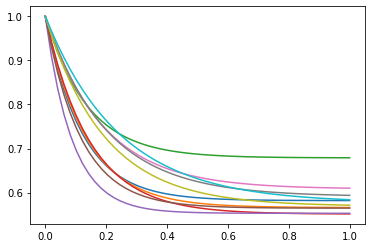

In [1]:
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import data
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import torch

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    mygenerator = pickle.load(f)
vals = np.linspace(0,1)
mymodels = mygenerator.get_models(10)
for k in mymodels:
    plt.plot(vals, k(vals));

## Prepare data

In [2]:
X, y = data.GenerateData()
Y = data.OneHot(y, 4)
X.shape, Y.shape

((2, 80), (4, 80))

## Try to get aged theta

In [25]:
import importlib
importlib.reload(pnn)

# generate NN, the initial time, i.e., pnn.PNNLayer.t = 0.
mypnn = torch.nn.Sequential(pnn.PNNLayer(2,3, mygenerator), pnn.PNNLayer(3,4, mygenerator))
counter = 1
for i in mypnn:
    print(f"The {counter}-th layer:")
    counter += 1
    
    print(f"theta at t={i.t}\n", i.theta)    # print theta
    i.t = 0.1         # change time
    print(f"theta at t={i.t}\n", i.theta)    # print aged theta
    
    print("\n")

The 1-th layer:
theta at t=0
 tensor([[ 0.4644,  0.1907,  0.2065,  0.4841],
        [ 0.7518,  0.2392,  2.3888, 10.2198],
        [ 0.9248,  0.4282,  2.3538,  9.8856]],
       grad_fn=<g_straight_throughBackward>)
theta at t=0.1
 tensor([[0.3361, 0.1835, 0.1540, 0.3492],
        [0.5584, 0.1937, 1.7501, 9.1118],
        [0.7324, 0.3035, 1.8619, 7.7630]],
       grad_fn=<g_straight_throughBackward>)


The 2-th layer:
theta at t=0
 tensor([[5.5799e-01, 3.6155e-01, 3.4688e-01, 2.7235e+00, 1.1589e+01],
        [9.8163e-01, 9.7237e-01, 8.1244e-01, 1.7412e+01, 7.8015e+01],
        [8.5025e-01, 2.7036e-02, 3.5195e-01, 9.6367e+00, 4.3383e+01],
        [6.6461e-01, 1.9925e-01, 4.0488e-02, 5.8186e+00, 2.5860e+01]],
       grad_fn=<g_straight_throughBackward>)
theta at t=0.1
 tensor([[4.4420e-01, 2.8163e-01, 2.8864e-01, 2.0617e+00, 8.5402e+00],
        [7.2844e-01, 7.2940e-01, 6.4291e-01, 1.3172e+01, 6.0524e+01],
        [6.6791e-01, 1.9109e-02, 3.2779e-01, 8.0919e+00, 3.2342e+01],
        [4.548